In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import xarray as xr
import scipy.fft as fft

# Lab 2.1 

1. Generate a realization of an OU process with 10^5 steps, using dt=0.001 and $\tau$=1, and plot it.
2. Verify that your simulation worked by comparing the variance to the analytic solution.
3. Using the same time step and length, vary $\tau$.  What do you notice happens when you make $\tau$ very large or very small?
4. Generate realizations of the OU process with 10^6 steps, using dt=0.001 and $\tau$=1, (note this will take about 10 seconds or so) and save it as a netcdf file. Load your netcdf file afterwards to show that it is working.

Hint 

Hint: to save something as a netcdf file there are 2 steps:
1. declare a DataArray, and set some variables and attributes, here I'm assuming that I generated an OU process like x(t) : 
```
ds=xr.Dataset(data_vars={'x':('t',x)},
                coords={'t':('t',t)},
                attrs={'description':'1D OU data',
                        'noise strength': '1',
                        'tau':'1'}
                )
```
The data_vars and coordinates are python dictionaries, that have the keys set to be the name we want to save with. The values are tuples, where the first entry is the dimension the data has, and the second is the data that we are storing.

2. save that dataArray using to netcdf using ```ds.to_netcdf('/file/path/to/somewhere/theFileName.nc')```


/tmp/ipykernel_12489/128543491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i]=np.exp(-dt/tau)*X[i-1]+s*np.sqrt(dt)*np.random.randn(1)


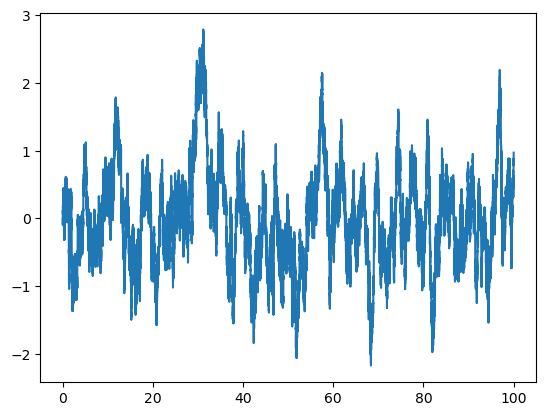

In [4]:
def simulate_ou(dt=1e-3,
                tau=1,
                N=int(1e5),
                s=1):
    
    t=np.arange(0,N*dt,dt)
    X=np.zeros(N)   
    s=1

    for i in range(1,N):
        X[i]=np.exp(-dt/tau)*X[i-1]+s*np.sqrt(dt)*np.random.randn(1)

    return t,X

t,x=simulate_ou()
plt.plot(t,x)

In [5]:
print('numerical value of variance: ', np.var(x))
print('analytical value of variance:', 1**2*1/2 )

numerical value of variance:  0.5178858910179591
analytical value of variance: 0.5


/tmp/ipykernel_12489/128543491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i]=np.exp(-dt/tau)*X[i-1]+s*np.sqrt(dt)*np.random.randn(1)


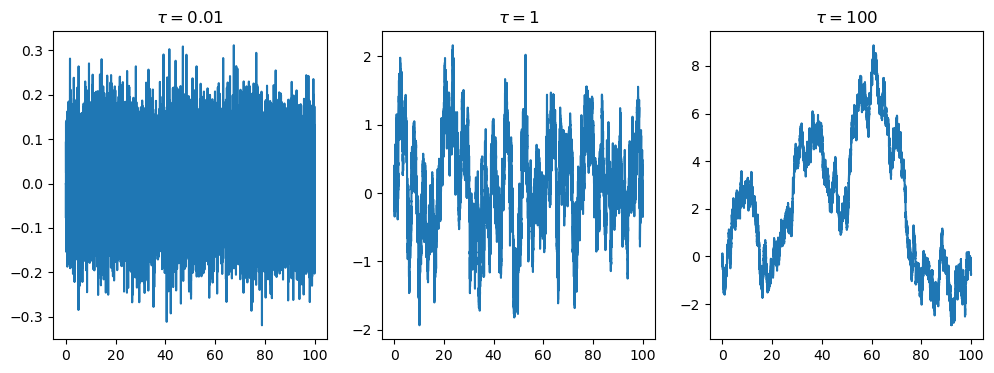

In [6]:
taul=[0.01,1,100]
fig,axs=plt.subplots(1,3,figsize=(12,4))
for i,tau in enumerate(taul):
    t,x=simulate_ou(tau=tau)
    axs[i].plot(t,x)
    axs[i].set_title(f'$\\tau={tau}$')

In [8]:
t,x=simulate_ou(N=int(1e6))

ds=xr.Dataset(data_vars={'x':('t',x)},
                coords={'t':('t',t)},
                attrs={'description':'1D OU data',
                        'noise strength': '1',
                        'tau':'1'}
                )

ds.to_netcdf('../data/1DOULong.nc')

/tmp/ipykernel_12489/128543491.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i]=np.exp(-dt/tau)*X[i-1]+s*np.sqrt(dt)*np.random.randn(1)


# Lab 2.2

1. Load the data that you saved in the previous lab, and calculate the autocovariance and aucorrelation. 
   1. Start using 1e4 samples and 1e4 lags. Vary the number of samples until you are happy with the estimate. How many samples did you have to use? 
   2. Add a line to your plot testing the hypothesis that the correlation is different from 0 with $p=0.05$
2. Split your OU data into 1000 subsections of equal length, and calculate the mean from each length. 
   1. Compare this to the known value of the mean for your simulation.
   2. How many data points do you think you need in order to reliably calculate the mean? How does this relate to the parameters of the process that you simulated? 
3. Load the data in MTLWstation_T2m.nc and calculate the autocorrelation using 30*24=720 lags 
   1. How does this example compare to the previous example?

In [6]:
def get_autocorrelation(X,
                        nlags=10000,
                        ):

    a = X-np.mean(X)
    C = np.zeros(nlags)
    for i in range(1,nlags):
        C[i] = np.sum( a[:-i] * a[i:])/len(X)
    C[0] = np.mean(a**2 )

    lags=np.arange(0,nlags)

    return lags,C/C[0]


In [7]:
dso = xr.open_dataset('../data/1DOULong.nc')
dso

<xarray.Dataset>
Dimensions:  (t: 1000000)
Coordinates:
  * t        (t) float64 0.0 0.001 0.002 0.003 0.004 ... 1e+03 1e+03 1e+03 1e+03
Data variables:
    x        (t) float64 ...
Attributes:
    description:     1D OU data
    noise strength:  1
    tau:             1

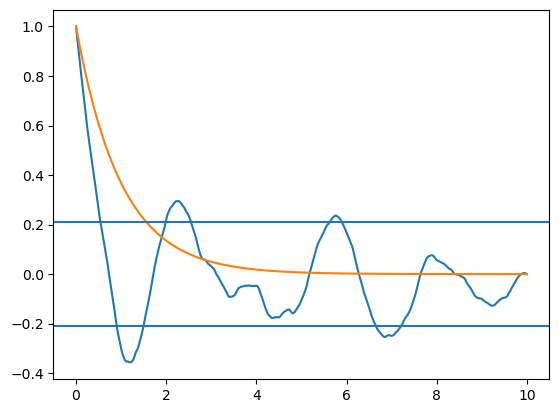

In [8]:
lags1,acf_1=get_autocorrelation(dso.x.data[:int(1e4)],nlags=int(1e4))
dt=1e-3
plt.plot(dt*lags1,acf_1)
plt.plot(dt*lags1,np.exp(-lags1*dt))
plt.axhline(2/(np.sqrt(9e4*dt/1)))
plt.axhline(-2/np.sqrt(9e4*dt/1))

In [9]:
dsw=xr.open_dataset('/home/rfajber/ResearchMethodsCourse/data/MTLWstation_T2m.nc')


In [10]:
lags2,acf_2=get_autocorrelation(dsw.T2m.data,nlags=int(365*24))

(0.0, 240.0)

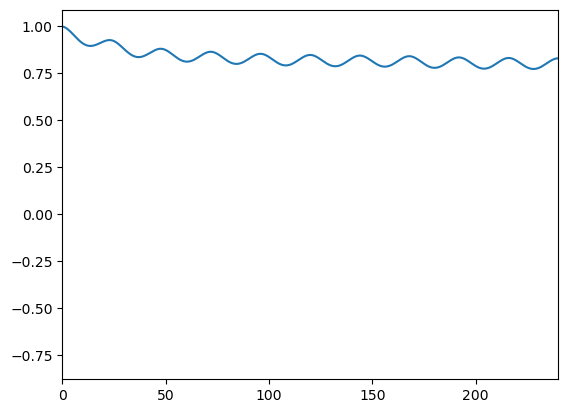

In [11]:
plt.plot(lags2,acf_2)
plt.xlim([0,10*24])

# Lab 2.3 

## Generating data with the stochastic oscillator 
1. Generate a realization of the stochastic oscillator using dt=0.001, $\tau=2$ and $f=1$.
2. Vary $f$ and test what it does to the realizations. What happens in the limits as $f/\tau$ becomes large and small?
3. Save off a realization of length 10^6 with the default parameters to use in the future. 

## Calculating covariance and Autocovariance 
1. Calculate the lagged autocorrelation of the 2 components of the stochastic oscillator.
2. Is there any insight that you can get about the weather station data from this calculation?   

In [12]:
def simulate_oscillator(
    dt = 0.001,
    N = int(1e4),
    tau_relax = 2,
    tau_rotate = 1
    ):

    t = np.arange(0,N*dt,dt),        

    X = np.zeros([2,N])

    A = np.array([
                [0,2*np.pi/tau_rotate ],
                [-2*np.pi/tau_rotate,-1/tau_relax]])
    Am = la.expm(A*dt)

    s = np.sqrt(2/(np.sqrt(tau_relax)))
    B = np.array([s,s])*np.sqrt(dt)

    for i in range(1,N):
        w = np.random.randn(2)
        X[:,i] = np.dot( Am, X[:,i-1] ) + B*w

    return t[0],X

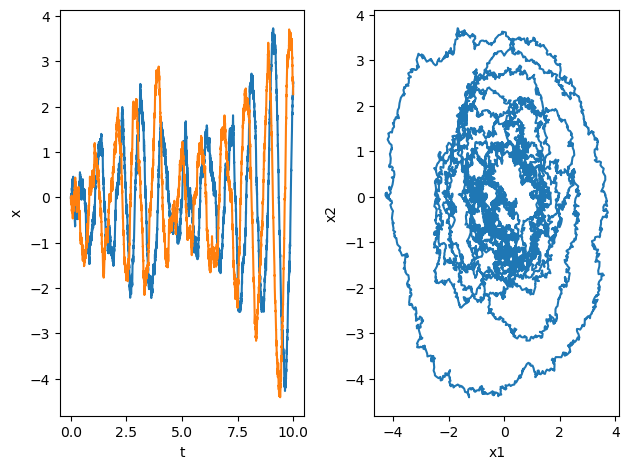

In [13]:
t,X=simulate_oscillator()

plt.subplot(1,2,1)
plt.plot(t,X[0,:])
plt.plot(t,X[1,:])
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(1,2,2)
plt.plot(X[0],X[1])
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()

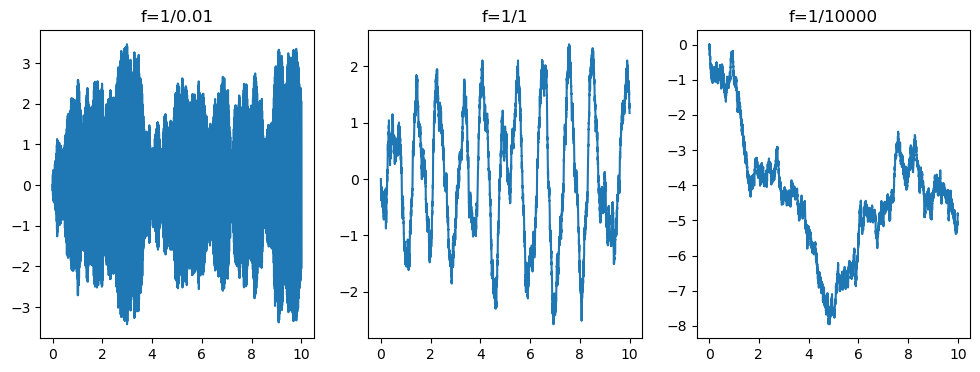

In [14]:
fl=[0.01,1,10000]
fig,axs=plt.subplots(1,3,figsize=(12,4))
for i,tau in enumerate(fl):
    t,x=simulate_oscillator(tau_rotate=tau,tau_relax=1)
    axs[i].plot(t,x[0])
    axs[i].set_title(f'f=1/{tau}')

In [15]:
t,x=simulate_oscillator(N=int(1e6))

ds=xr.Dataset(data_vars={'x':(('dim','t'),x)},
                coords={'t':('t',t),
                        'dim':('dim',np.array((0,1)))},
                attrs={'description':'2D OU data',
                        'noise strength': '1',
                        'tau_relax':'1',
                        'tau_rotate':'2'}
                )

ds.to_netcdf('../data/2DOULong.nc')

In [16]:
def get_crosscorrelation(X,
                         Y,
                        nlags=int(1e4),
                        ):
    a = X-np.mean(X)
    b = Y-np.mean(Y)
    C = np.zeros(nlags)
    for i in range(1,nlags):
        C[i] = np.sum( a[:-i] * b[i:])/len(X)
    C[0] = np.mean(a*b)

    lags=np.arange(0,nlags)

    return lags,C/C[0]
    

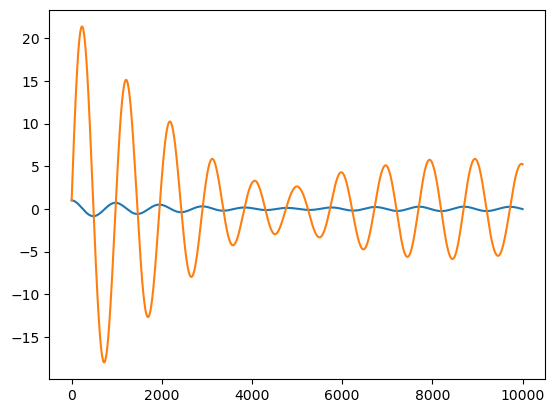

In [17]:
t,X=simulate_oscillator(N=int(1e5))
lags4,acf_4 = get_crosscorrelation(X[0],X[1],
                                   nlags=int(1e4))
lags3,acf_3 = get_crosscorrelation(X[1],X[1],
                                   nlags=int(1e4))
plt.plot(lags3,acf_3)
plt.plot(lags4,acf_4)

# Lab 3.1 

1. Load the and calculate the power spectrum for:
   1. the 1D OU process
   2. 1 component of the stochastic oscillator 
   3. MTLWstation_T2m.nc
2. Compare the power spectrum from the different datasets. What do you notice? What can you conclude about the Montreal weather data?

In [18]:
ds1=xr.open_dataset('../data/1DOULong.nc')
x1=ds1.x.data
ds2=xr.open_dataset('../data/2DOULong.nc')
x2=ds2.x.isel(dim=1).data
ds3=xr.open_dataset('../data/MTLWstation_T2m.nc')
x3=ds3.T2m.data

In [19]:
def rednoise_spec(
        f,
        s=1,
        tau=1,
):
    S = (2.0*s/tau)/((1/tau)**2+(2*np.pi*f)**2)

    return S

def rednoise_periodic_spec(        
        f,
        s=1,
        tau_relax=2,
        tau_rotate=1
):
    S = (s/tau_relax)* ( 1/((1/tau_relax)**2+(4*np.pi**2*(f-1/tau_rotate)**2))+1/((1/tau_relax)**2+(4*np.pi**2*(f+1/tau_rotate)**2) ) )

    return S


In [20]:
f=fft.fftshift(fft.fftfreq(len(x2),d=0.001))
X=fft.fft(x2)
P=fft.fftshift(X*np.conj(X))
np.trapz(x=f,y=P/(0.5*len(x)**2))

(1554656814.6056707-8.709979431763079e-20j)

In [21]:
len(X)/10**6

1.0

In [22]:
np.var(x2)/np.trapz(x=f,y=P)

(9.999934933780772e-10+5.60247295569806e-38j)

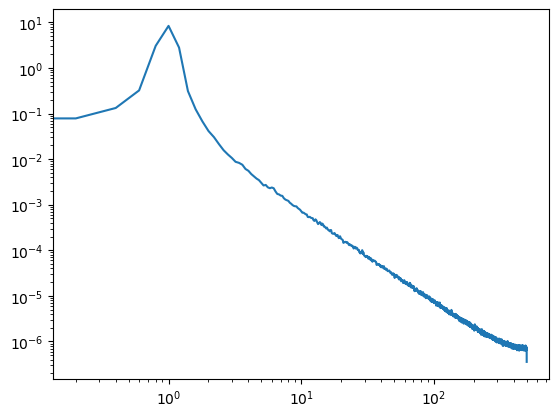

In [23]:
import scipy.signal as sig
import scipy.stats as st
fw,pw=sig.welch(x2,fs=1/0.001,nperseg=int(5e3))
plt.loglog(fw,pw)

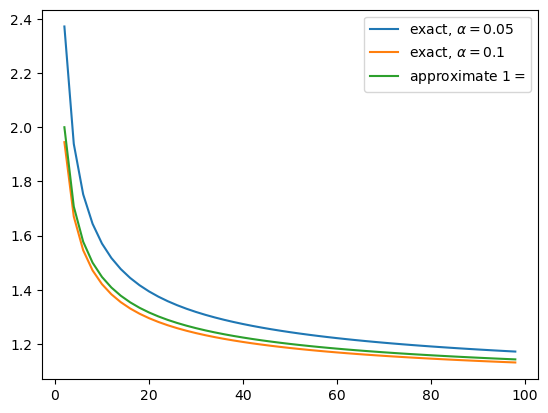

In [24]:
n=np.arange(2,100,2)
plt.plot(n,st.chi2.ppf(0.95,2*n)/(2*n),'-',
         label='exact, $\\alpha=0.05$')
plt.plot(n,st.chi2.ppf(0.9,2*n)/(2*n),'-',
         label='exact, $\\alpha=0.1$')
plt.plot(n,1+2./np.sqrt(2.*n),'-',
         label='approximate $1=\frac{2}{\\sqrt{n}}$')
plt.legend()

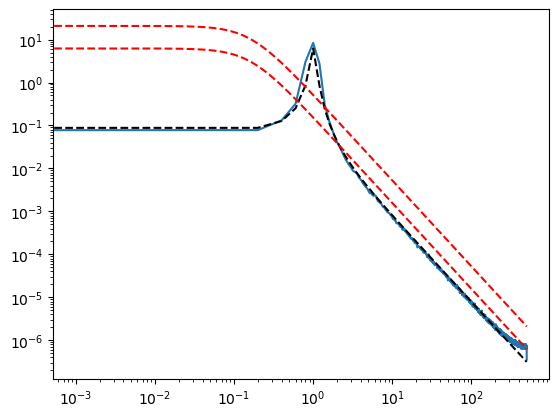

In [25]:
f=fft.fftshift(fft.fftfreq(len(x2),d=0.001))
X=fft.fft(x2)
P=fft.fftshift(X*np.conj(X))/len(X)

fw,pw=sig.welch(x2,fs=1/0.001,nperseg=int(5e3))

#plt.loglog(f,P*dt*2,alpha=0.5)
plt.loglog(fw,pw)
plt.loglog(fw,rednoise_periodic_spec(fw,s=np.var(x2)),'k--')
plt.loglog(f,rednoise_spec(f,s=np.var(x2)),'r--')
plt.loglog(f,st.chi2.ppf(0.95,2*10-1)/9*rednoise_spec(f,s=np.var(x2)),'r--')


In [26]:
print(np.trapz(x=fw,y=pw))
print(np.trapz(x=f,y=rednoise_spec(f,s=np.var(x2))))
print(np.trapz(x=f,y=rednoise_periodic_spec(f,s=np.var(x2))))

3.1011791969837117
3.10866332289955
3.1089783592231948


In [27]:
f=fft.fftshift(fft.fftfreq(len(x1),d=1e-3))
print(np.trapz(f,rednoise_spec(f,s=np.var(x1),tau=1)))

X=fft.fft(x1)
P=fft.fftshift(X*np.conj(X))/(0.5*len(X)**2)
np.trapz(f,P)


-0.4972481211675487


(-0.0009948209871224283-8.579915838504104e-25j)

In [28]:
print(np.sum(np.abs(x2)**2*dt))
print(np.var(x2)/dt)
X=fft.fft(x2)
P=fft.fftshift(X*np.conj(X))/(2*len(X)**2)
df=f[1]-f[0]
print(np.sum(P*df))

3109.313629321484
3109.2933980831167
(0.0015546568146239796-4.833400365791457e-37j)


In [29]:
print(np.sum(np.abs(x1)**2*dt))
print(np.var(x1)/dt)
X=fft.fft(x1)
P=fft.fftshift(X*np.conj(X))/(2*len(X))
df=f[1]-f[0]
print(np.sum(P*df))

497.51219097201454
497.44973013738013
(248.75609548012483-1.2282954999461107e-32j)


In [30]:
print(np.sum(x1**2)*dt)
X=fft.fft(x1)
print(dt*np.sum(np.abs(X)**2)/(len(X)))

497.51219097201465
497.51219097201454


/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


/tmp/ipykernel_12438/1568344680.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,f[-1]])


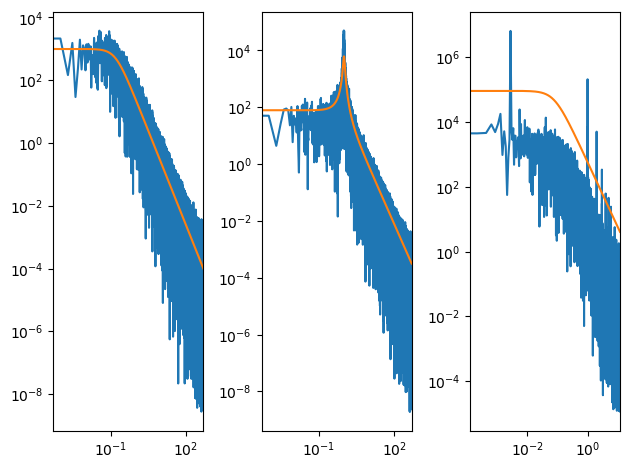

In [31]:
dtl=[1e-3,1e-3,1/24]
f=fft.fftshift(fft.fftfreq(len(x1),d=1e-3))
f3=fft.fftshift(fft.fftfreq(len(x3),d=1/24))
Sl=[
    rednoise_spec(f,s=np.sum(x1**2)*dt,tau=1),
    rednoise_periodic_spec(f,s=np.sum(x2**2)*dt,tau_relax=2,tau_rotate=1),
    rednoise_spec(f3,s=np.sum(x3**2)*dt,tau=2)
]

for i,x in enumerate([x1,x2,x3]):
    X=fft.fft(x)
    f=fft.fftshift(fft.fftfreq(len(x),d=dtl[i]))
    plt.subplot(1,3,i+1)
    P=fft.fftshift(X*np.conj(X))/(len(X))
    plt.loglog(f,P)
    plt.loglog(f,Sl[i])
    plt.xlim([0,f[-1]])

plt.tight_layout()

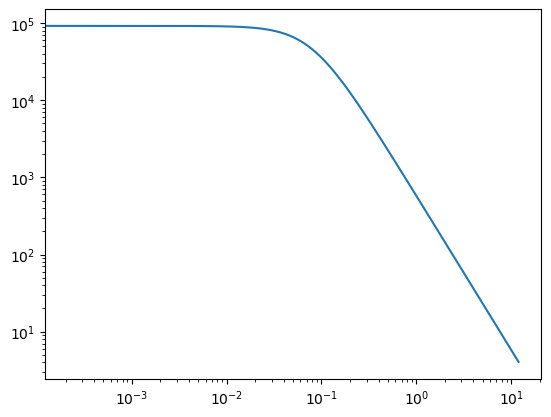

In [32]:
plt.loglog(f3,Sl[2])

In [33]:
x2

array([0.        , 0.04114024, 0.03268872, ..., 1.19537479, 1.14156156,
       1.16810537])

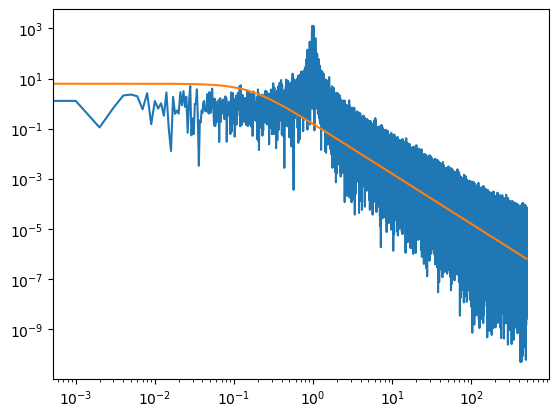

In [34]:
v=np.var(x2)
f=fft.fftshift(fft.fftfreq(len(x2),d=0.001))
S = rednoise_spec(f,
                  s=v,
                  tau=1)

P = fft.fftshift(fft.fft(x2)*np.conj((fft.fft(x2))))

plt.loglog(f,P*dt**2/(2*np.pi)**2)
plt.loglog(f,S)

In [35]:
r=np.random.randn(100000)

R=fft.fft(r)
P=fft.fftshift(R*np.conj(R))/len(r)
f=fft.fftshift(fft.fftfreq(len(r)))
print(np.var(r))
print(np.trapz(f,P))


0.9973407128126239
(-0.6114626125220489-2.7179227908278005e-18j)


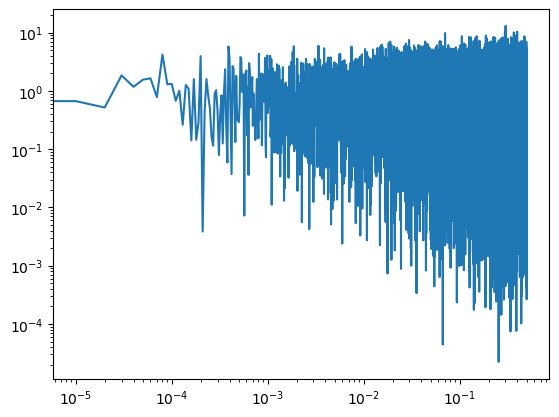

In [36]:
plt.loglog(f,P)